In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load Dataset

Dataset Original Length n:  10358
Dataset Sampled Length n:  10358


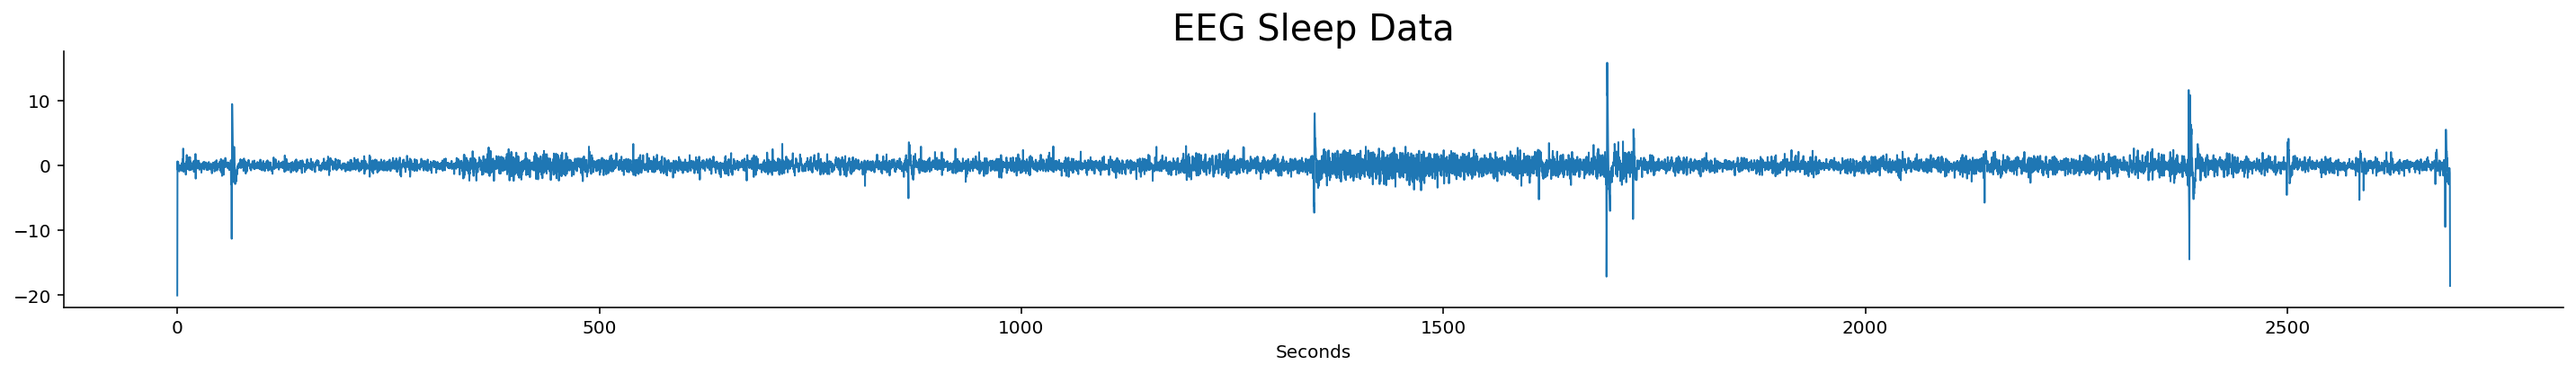

In [2]:
file = 'npo141.csv' # Dataset Length n:  269286
ds_name="EEG Sleep Data"
series = ml.read_dataset_with_index(file) 
data = series.values
#series = ml.as_series(data, np.arange(0, 269286, 26) / 100, 'Seconds')
plot_dataset(file, series, ds_name=ds_name)

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2
df_comp = pd.DataFrame(columns=["Method", "Motif", "Extent", "k"]) # Complete Info

rerun_all_jars = False
motif_length = 25
dataset = os.getcwd() + '/../datasets/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets/notebooks/../datasets/npo141.csv


# k-Motiflets

Compute ks: 100%|█████████████████████████████████████████████████████████████| 18/18 [00:19<00:00,  1.06s/it]


Chosen window-size: 25


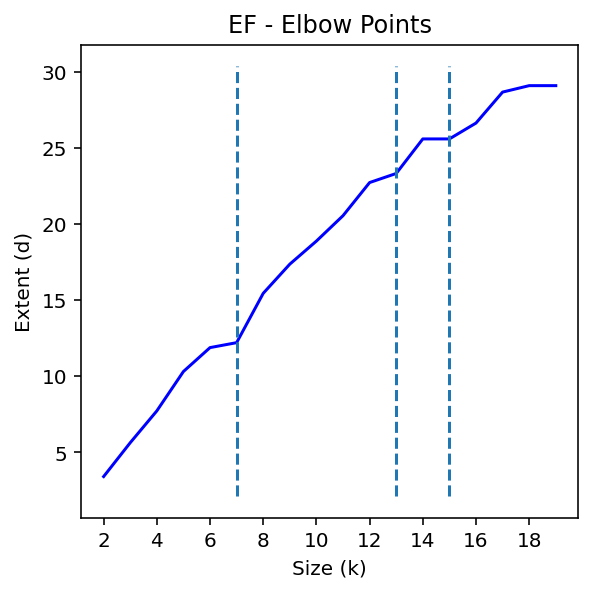

Identified Elbow Points [ 7 13 15]
Filtered Elbow Points [7, 13, 15]


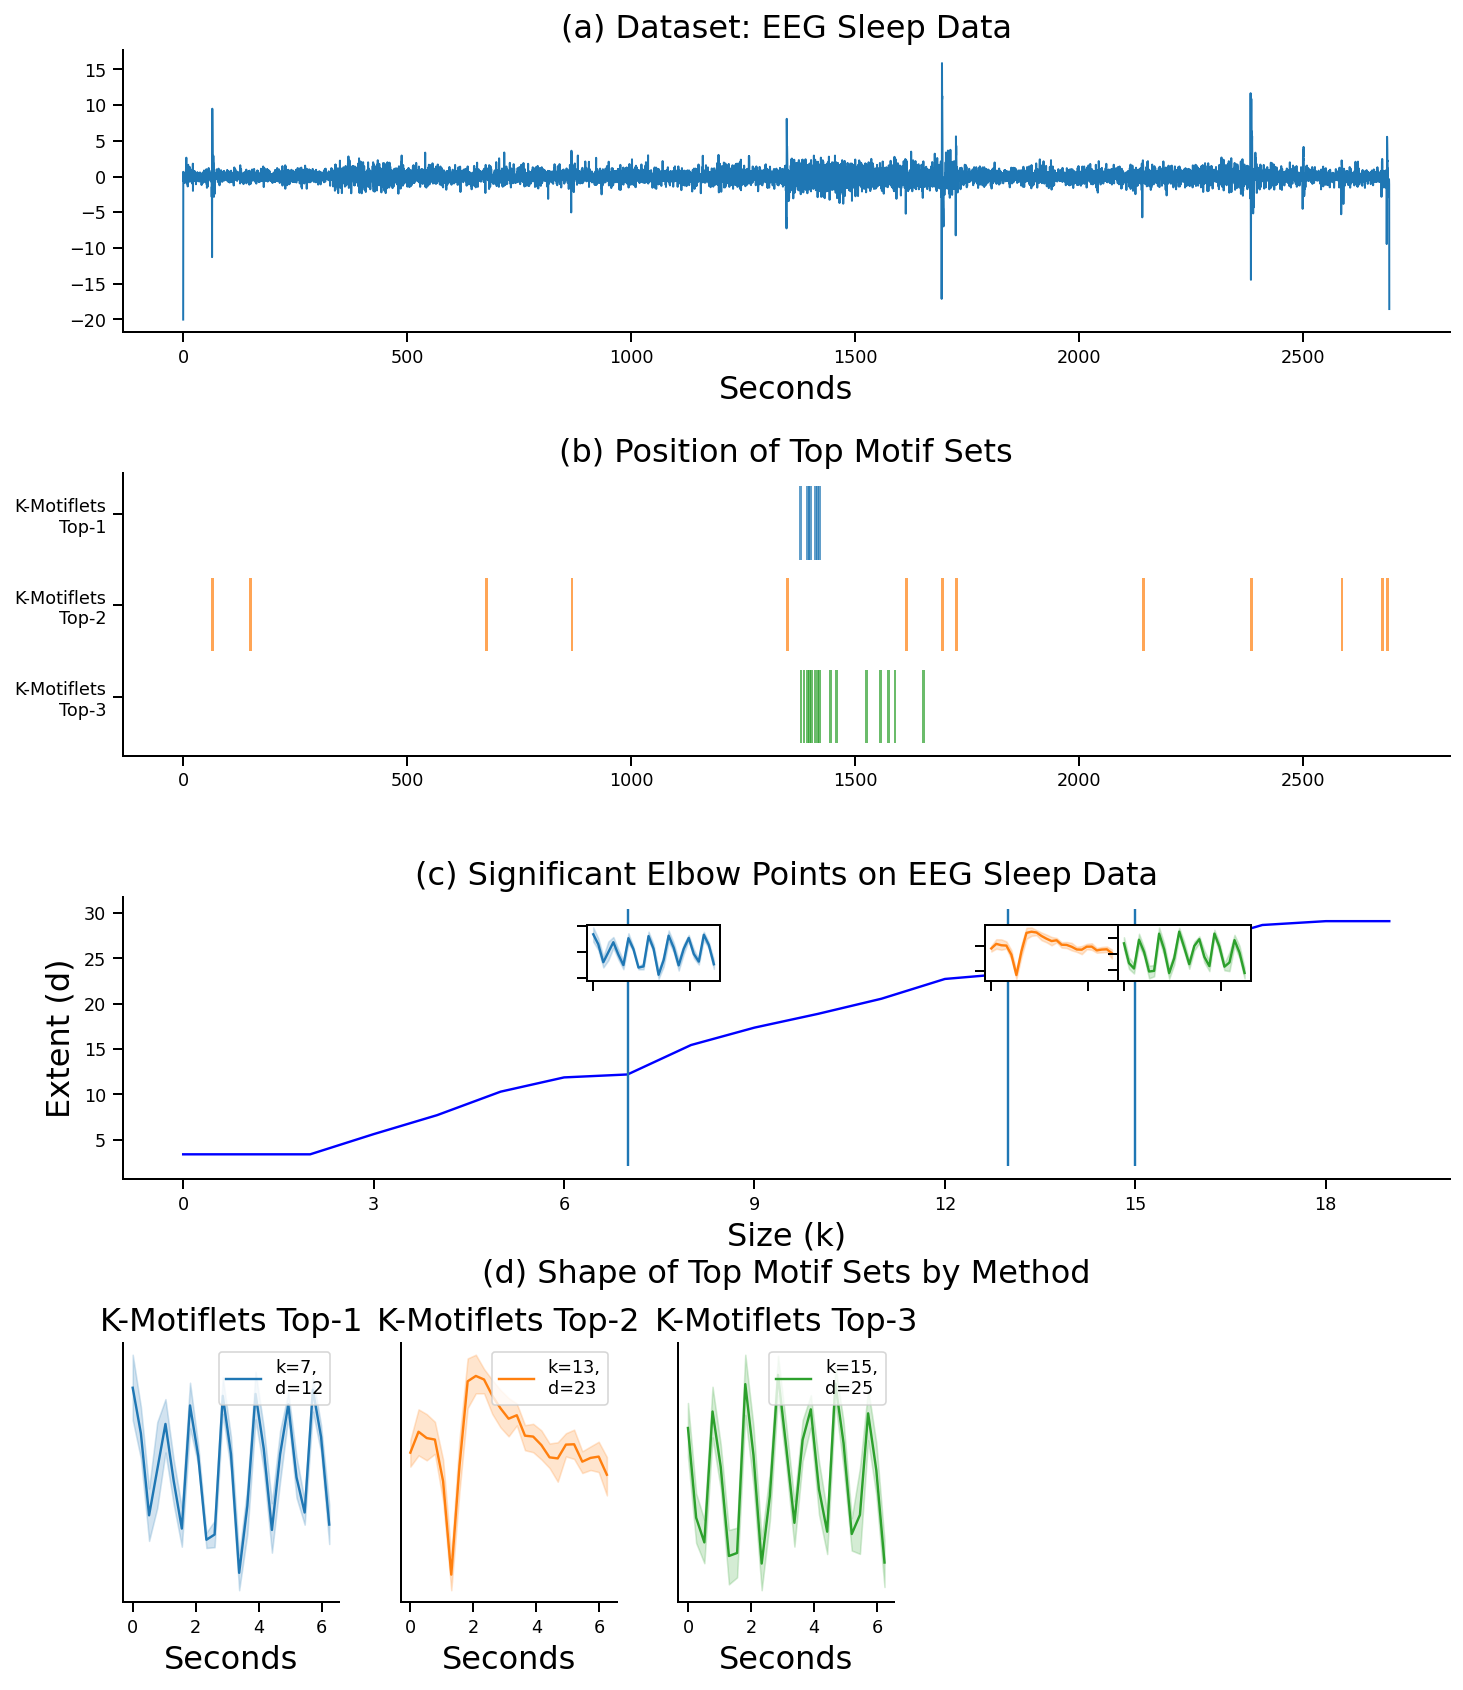

In [4]:
dists, motiflets, elbow_points = plot_elbow(
    20, series, file, ds_name=ds_name, plot_elbows=True, 
    motif_length=motif_length, method_name="K-Motiflets")

In [5]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]
df_comp = append_all_motif_sets(df_comp, motiflets, "Motiflets", D_full)

# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [6]:
max_r = 13
radii = np.arange(5, max_r + 1, max(1, int(max_r / 10)))
print("Radii", radii)

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(radii)),
       str(motif_length)])

Radii [ 5  6  7  8  9 10 11 12 13]


r: 6.1375756 d: 6.137575626373291
r: 6.898054 d: 10.434456825256348
r: 11.952562 d: 25.236347198486328
r: 12.078585 d: 25.127092361450195
r: 12.078585 d: 25.127092361450195
Filtered Elbow Points [1, 4]


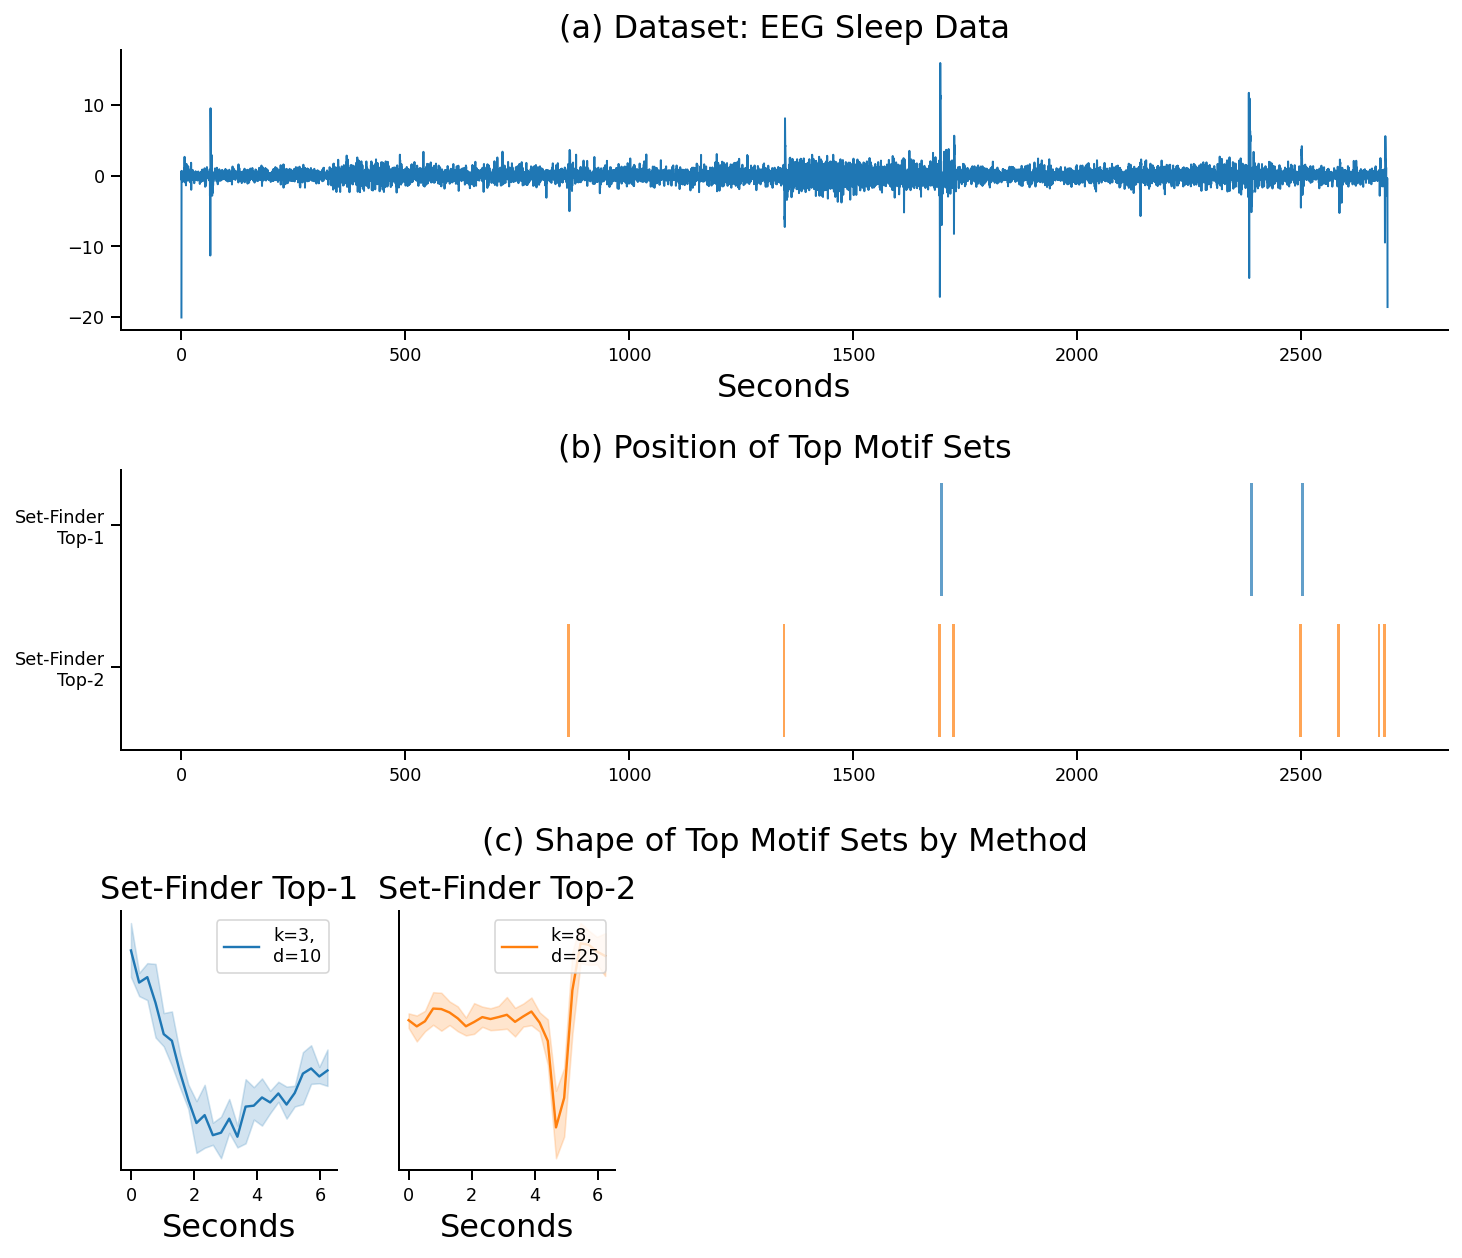

,Motiflets Top-1,Set Finder Top-1
0,"[5439, 5351, 5366, 5420, 5454, 5976, 5598, 531...","[6495, 3313, 5162, 6616, 9595, 9926, 10272, 10..."


In [7]:
# run jave code first       
ms_set_finder = [
	[6515, 9176],
	[6516, 9177, 9618],
	[6496, 5163, 6617, 9596, 10273, 10317],
	[6495, 3313, 5162, 6616, 9595, 10272, 10316],
	[6495, 3313, 5162, 6616, 9595, 9926, 10272, 10316],
	#[5431, 5373, 5416, 5485, 5510, 5586, 5690, 5722, 5744, 5778, 6360],
	#[5431, 5373, 5416, 5446, 5481, 5510, 5534, 5586, 5690, 5722, 5744, 5778, 6360],
	#[5430, 5346, 5372, 5415, 5445, 5480, 5509, 5577, 5589, 5689, 5721, 5743, 5777, 6359],
	#[5431, 5347, 5362, 5377, 5416, 5446, 5481, 5510, 5534, 5578, 5590, 5690, 5722, 5744, 5756, 5778, 5987, 6360],
	#[5430, 5346, 5361, 5376, 5411, 5445, 5480, 5509, 5533, 5577, 5589, 5689, 5721, 5743, 5755, 5777, 5833, 5982, 6054, 6074, 6332, 6359],
]

motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length, prefix="Set-Finder")
df["Set Finder Top-1"] = [motifset[-1]]
df2["Set Finder Top-2"] = [motifset[-2]]

df_comp = append_all_motif_sets(df_comp, ms_set_finder, "Set Finder", D_full)
df

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [8]:
max_r = 15
radii = np.arange(5, max_r + 1, max(1, int(max_r / 10)))
print("Radii", radii)

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(radii)),
       str(motif_length)])

Radii [ 5  6  7  8  9 10 11 12 13 14 15]


r: 8.93558 d: 9.930319786071777
r: 6.7134404 d: 11.35396957397461
r: 13.565541 d: 13.56554126739502
r: 16.318604 d: 16.318603515625
r: 20.380539 d: 20.380538940429688
r: 23.617336 d: 25.225738525390625
Filtered Elbow Points [2, 3]


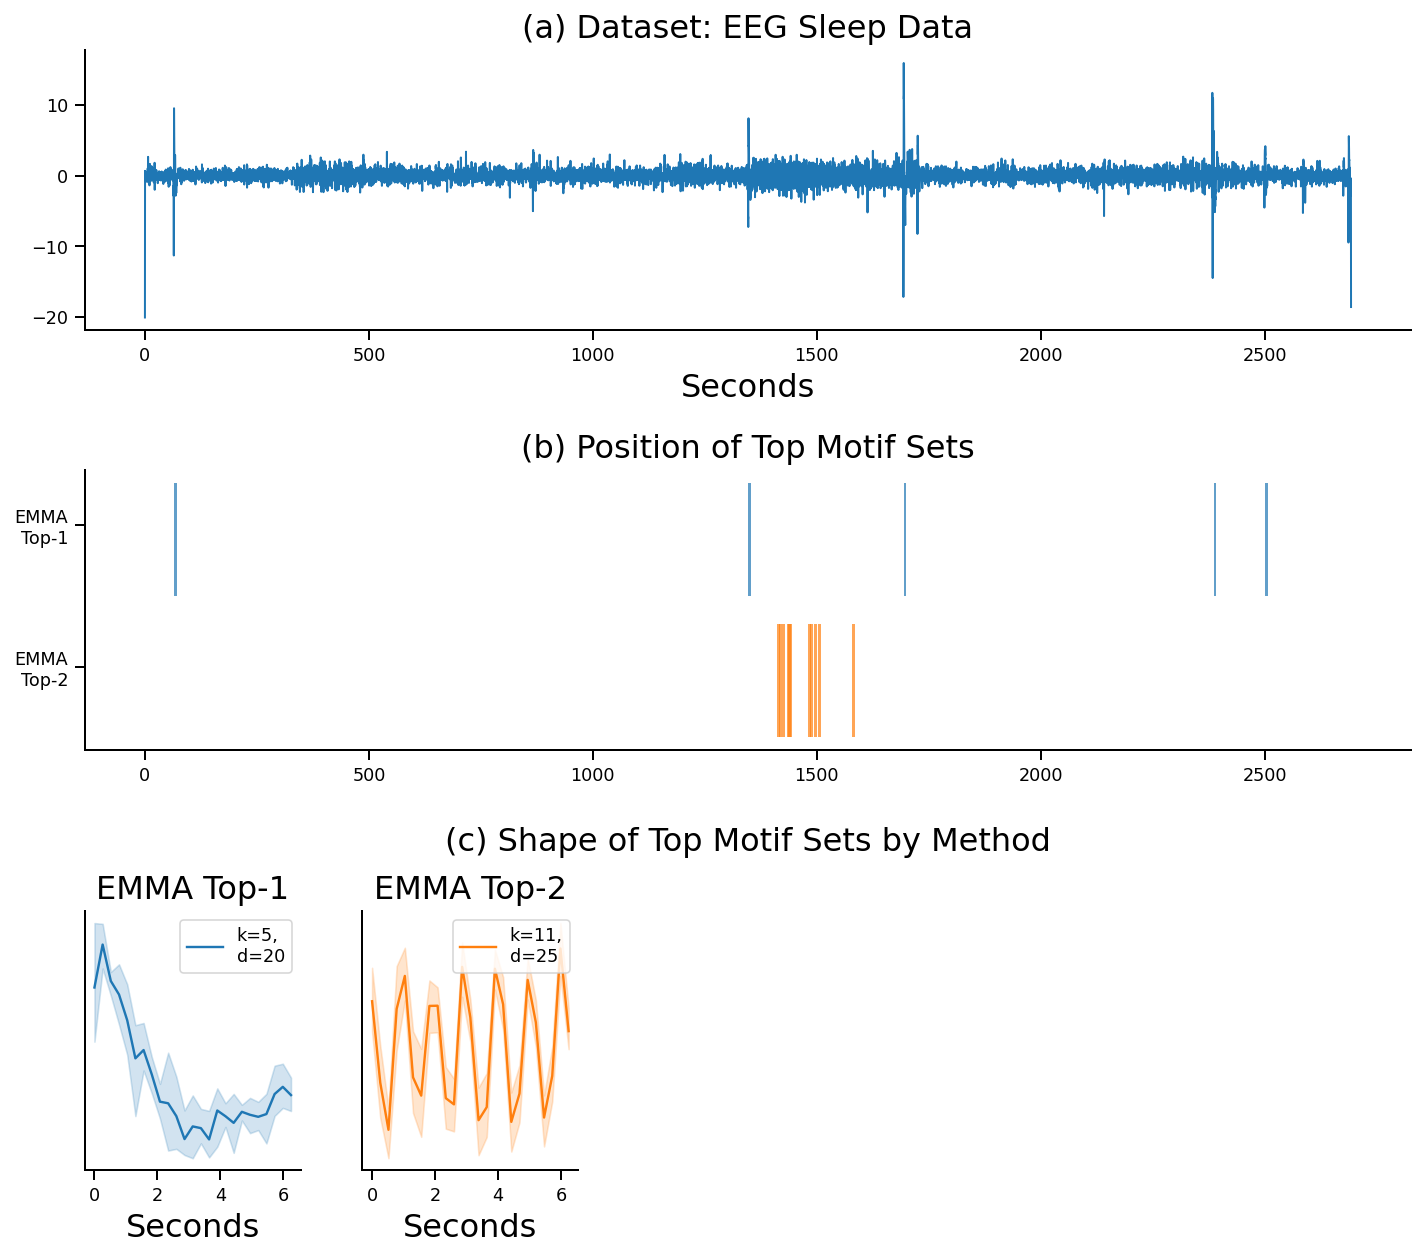

In [9]:
# run jave code first       
ms_emma = [
	[6515, 9177, 9617],
	[6515, 9176, 9617],
	[5182, 6636, 9177, 9617],
	[5183, 6515, 9176, 9617],
	[250, 5182, 6515, 9176, 9617],
#	[250, 2712, 5182, 6636, 9113, 9177, 9616],
	[5427, 5446, 5473, 5510, 5522, 5534, 5694, 5714, 5748, 5782, 6071],
#	[5373, 5427, 5446, 5473, 5485, 5510, 5522, 5534, 5694, 5710, 5748, 5782, 6071],
#	[5358, 5373, 5427, 5446, 5461, 5473, 5485, 5510, 5522, 5534, 5694, 5710, 5722, 5748, 5782, 5819, 6071],
]

motifset = plot_competitors(series, ds_name, ms_emma, motif_length, prefix="EMMA")
df["EMMA Top-1"] = [motifset[-1]]
df2["EMMA Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_emma, "EMMA", D_full)

# Valmod Motif Sets
based on own (fixed-length) implementation

r: 3.3993237 d: 3.3993237018585205
r: 4.2799535 d: 6.116461277008057
r: 5.474304 d: 9.19970989227295
r: 12.520566 d: 13.235527992248535
r: 12.520566 d: 14.62498950958252
r: 12.520566 d: 19.18501091003418
r: 12.604938 d: 23.886924743652344
Filtered Elbow Points [6]


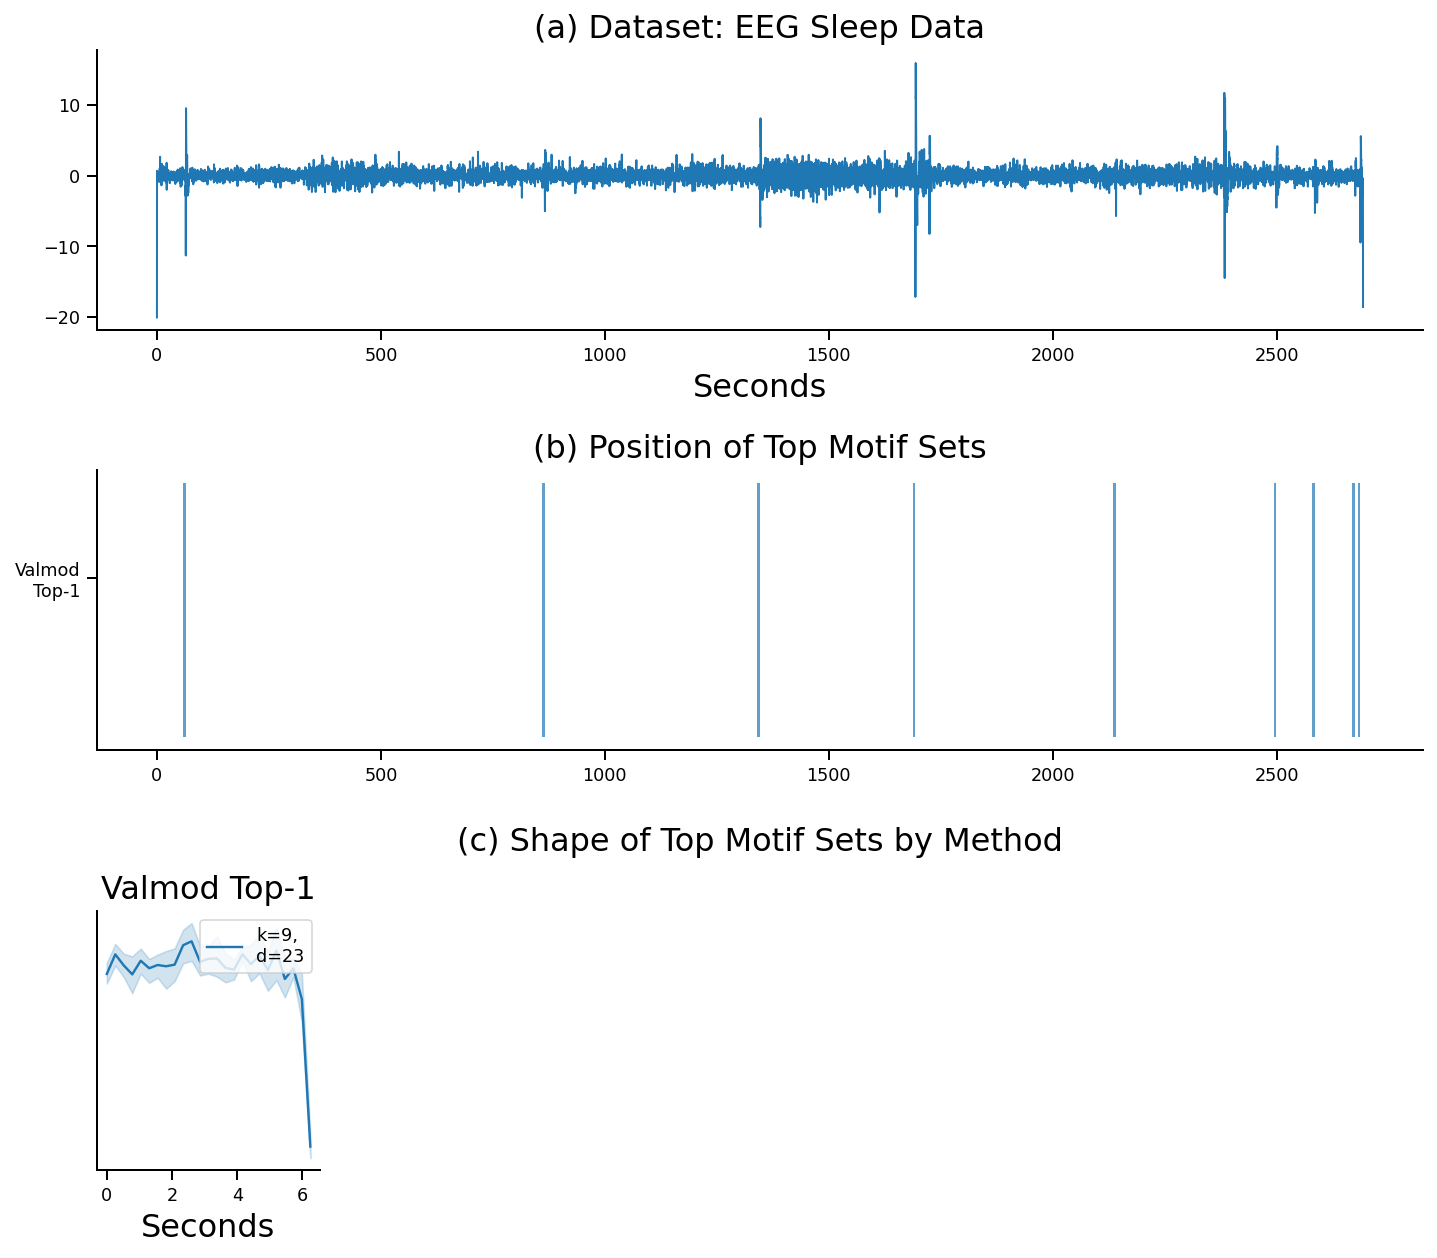

,Motiflets Top-1,Set Finder Top-1,EMMA Top-1,VALMOD Top-1
0,"[5439, 5351, 5366, 5420, 5454, 5976, 5598, 531...","[6495, 3313, 5162, 6616, 9595, 9926, 10272, 10...","[5427, 5446, 5473, 5510, 5522, 5534, 5694, 571...","[224, 3308, 5155, 6489, 8212, 9589, 9920, 1026..."


In [10]:
max_d = 15

ms_valmod = [motifset for (motifset, _) in get_valmod_motif_set_ranged(data, file, motif_length, max_d)]                                            
motifset = plot_competitors(series, ds_name, ms_valmod, motif_length, prefix="Valmod")
df["VALMOD Top-1"] = [motifset[-1]]
df2["VALMOD Top-2"] = [ms_valmod[0]]
df_comp = append_all_motif_sets(df_comp, ms_valmod, "VALMOD", D_full)
df

# Learning Motifs
See Java Code

In [11]:
max_r = 13
radii = np.arange(5, max_r + 1, max(1, int(max_r / 10)))
print("Radii", radii)

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(radii)),
       str(motif_length)])

Radii [ 5  6  7  8  9 10 11 12 13]


r: 8.378335 d: 8.378334999084473
r: 12.033663 d: 12.202153205871582
r: 14.18654 d: 16.355772018432617
r: 16.360634 d: 16.419315338134766
r: 16.360634 d: 16.419315338134766
r: 20.50355 d: 28.39600944519043
r: 20.50355 d: 28.39600944519043
Filtered Elbow Points [0, 2, 3]


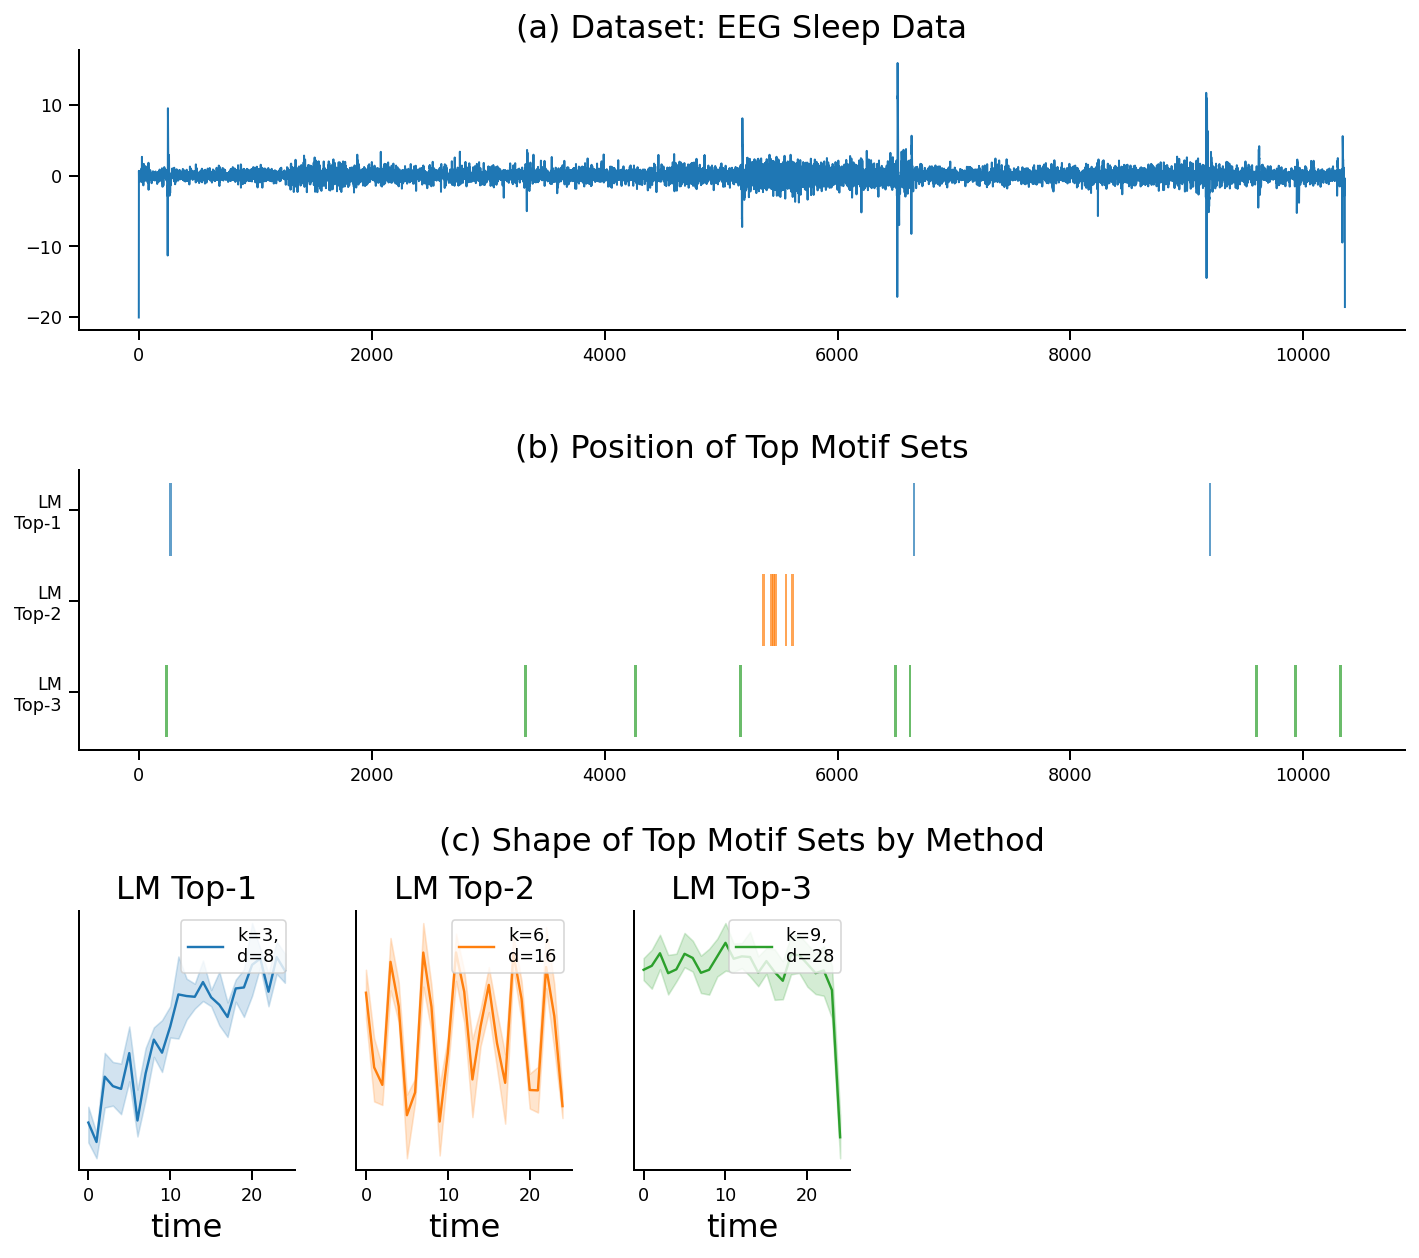

In [12]:
ms_learning_motifs = np.array([
	[263,6644,9187,],
	[5420,5439,5454,5598,],
	[5351,5420,5439,5454,5546,5598,],
	[5326,5351,5420,5439,5542,5598,],
	[5326,5351,5420,5542,5598,],
#	[5328,5353,5411,5509,5544,5596,5978,6347,],
	[224,3308,4254,5155,6489,6610,9589,9920,10310,],
	[224,3308,4254,5155,6489,6610,9589,9920,10310,],
#	[224,3110,3308,4254,5155,6489,6610,9145,9589,9920,10265,10310,],
])
    
motifset = plot_competitors(data, ds_name, ms_learning_motifs, 
                            motif_length, prefix="LM")

df["LM Top-1"] = [motifset[-1]]
df2["LM Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_learning_motifs, "LM", D_full)

# Comparison

In [13]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all

,offsets
Motiflets Top-1,"[5439, 5351, 5366, 5420, 5454, 5976, 5598, 531..."
Set Finder Top-1,"[6495, 3313, 5162, 6616, 9595, 9926, 10272, 10..."
EMMA Top-1,"[5427, 5446, 5473, 5510, 5522, 5534, 5694, 571..."
VALMOD Top-1,"[224, 3308, 5155, 6489, 8212, 9589, 9920, 1026..."
LM Top-1,"[224, 3308, 4254, 5155, 6489, 6610, 9589, 9920..."
Motiflets Top-2,"[6629, 10330, 6508, 243, 10285, 6200, 8231, 56..."
Set Finder Top-2,"[6516, 9177, 9618]"
EMMA Top-2,"[250, 5182, 6515, 9176, 9617]"
VALMOD Top-2,"[224, 10311]"
LM Top-2,"[5351, 5420, 5439, 5454, 5546, 5598]"


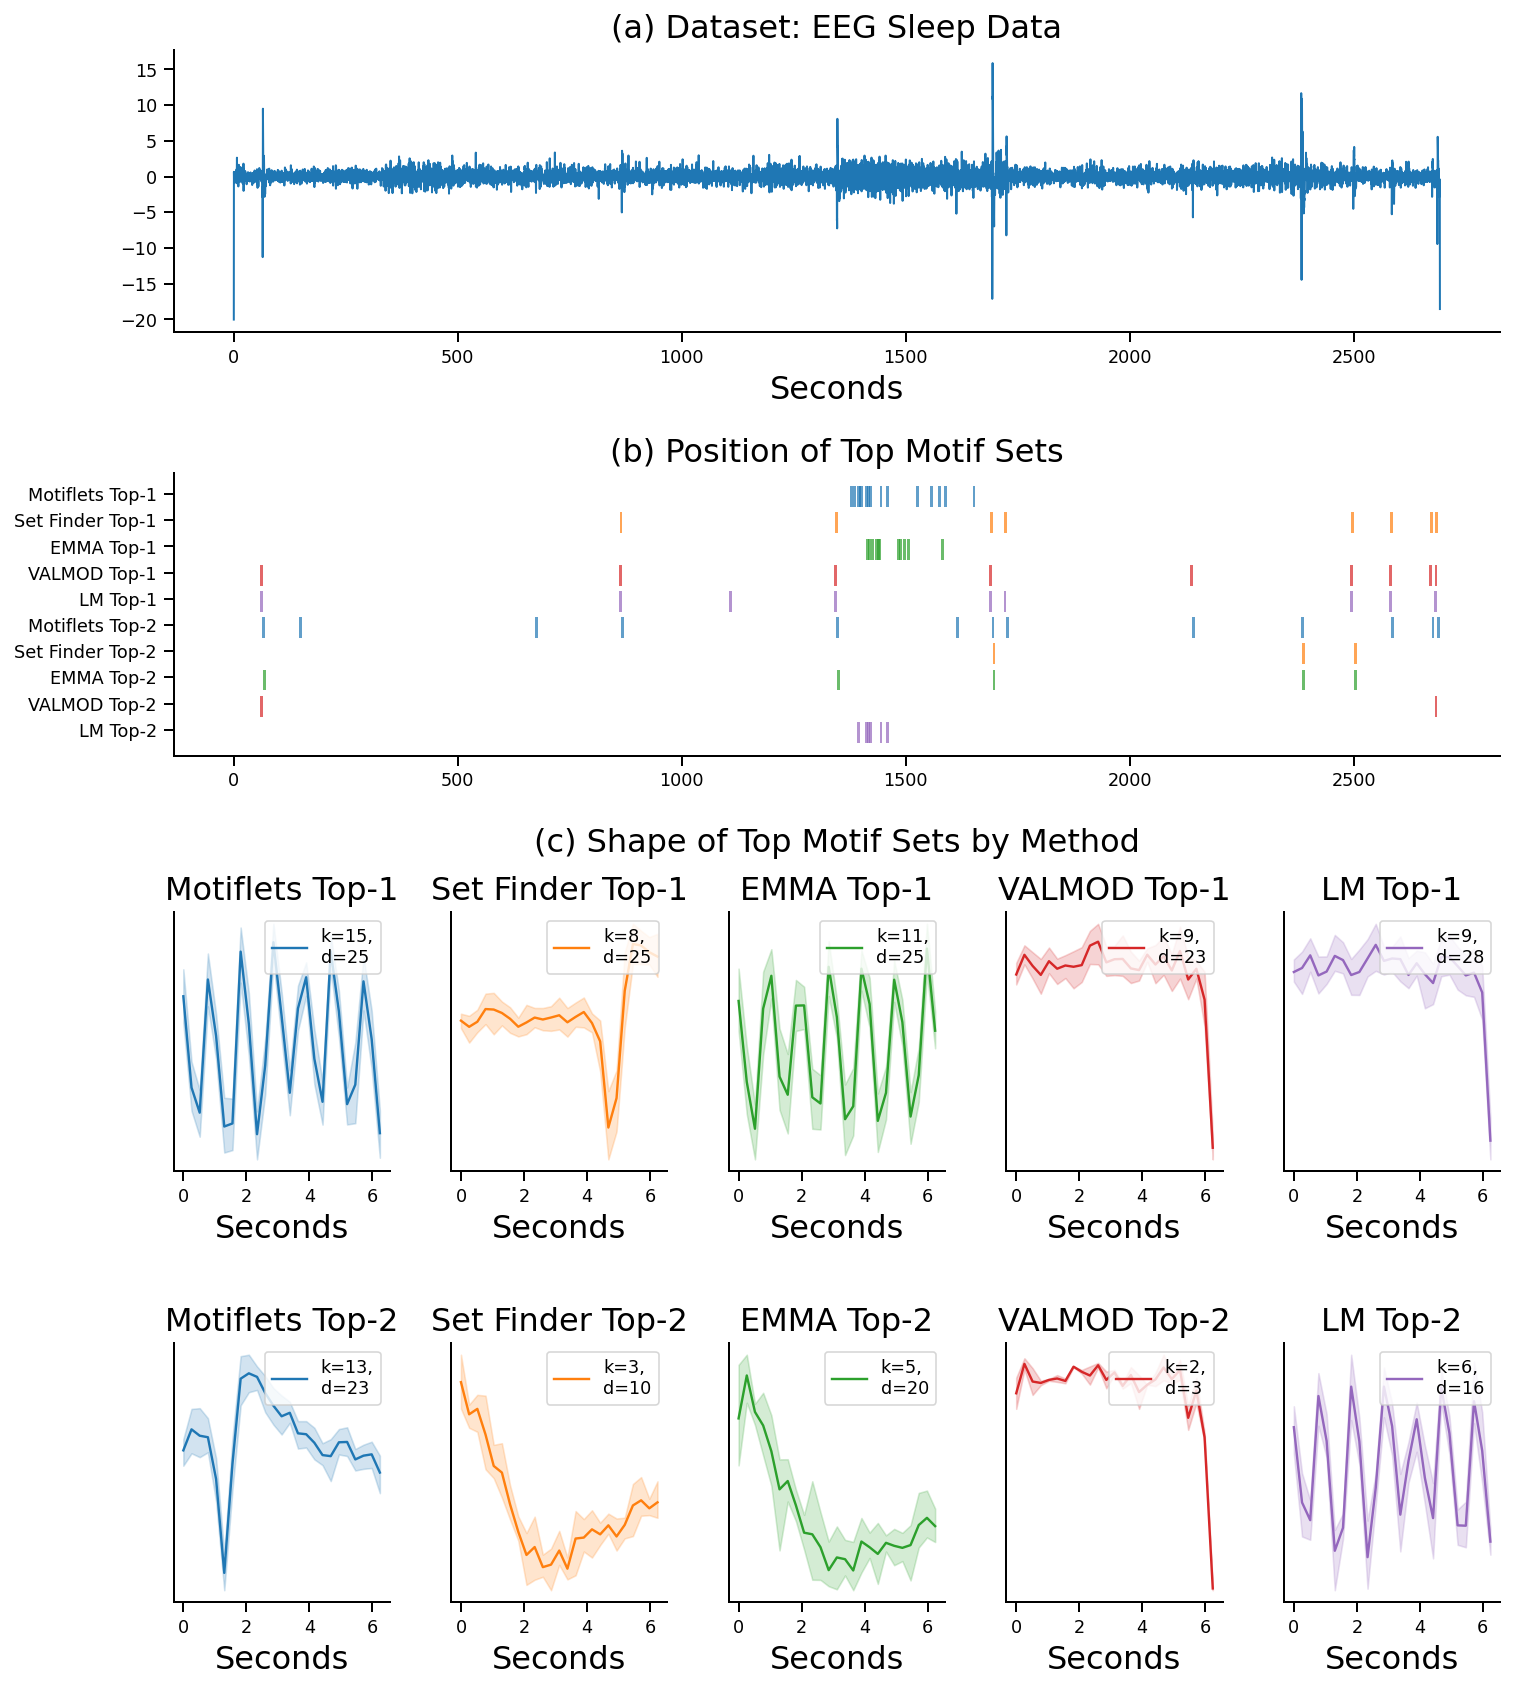

In [14]:
motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values)

# Summary

In [15]:
df_2 = df.T
df_2.rename(columns={0:"offsets"}, inplace=True)
df_2

,offsets
Motiflets Top-1,"[5439, 5351, 5366, 5420, 5454, 5976, 5598, 531..."
Set Finder Top-1,"[6495, 3313, 5162, 6616, 9595, 9926, 10272, 10..."
EMMA Top-1,"[5427, 5446, 5473, 5510, 5522, 5534, 5694, 571..."
VALMOD Top-1,"[224, 3308, 5155, 6489, 8212, 9589, 9920, 1026..."
LM Top-1,"[224, 3308, 4254, 5155, 6489, 6610, 9589, 9920..."


In [16]:
extent = [ml.get_pairwise_extent(D_full, df_2.offsets[ind]) for ind in df_2.index]
count = [len(df_2.offsets[ind]) for ind in df_2.index]

df_statistics = pd.DataFrame(
    data=zip(df_2.index, extent, count), 
    columns=["Method", "Extent (d)", "Size (k)"])
df_statistics["Dataset"] = ds_name
# df_statistics.set_index("Method", inplace=True)
display(df_statistics)

,Method,Extent (d),Size (k),Dataset
0,Motiflets Top-1,25.604525,15,EEG Sleep Data
1,Set Finder Top-1,25.127092,8,EEG Sleep Data
2,EMMA Top-1,25.225739,11,EEG Sleep Data
3,VALMOD Top-1,23.886925,9,EEG Sleep Data
4,LM Top-1,28.396009,9,EEG Sleep Data


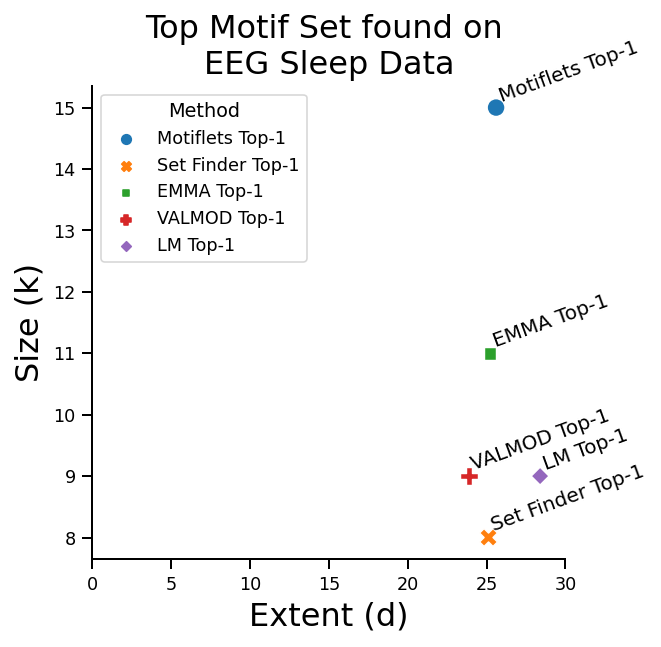

In [17]:
def annotate(ax, df):
    for ix, method, extent, cardinality, _ in df.itertuples():
        ax.annotate(
            method,
            (extent, cardinality+0.1),
            size = 10,
            rotation=+20
        )

fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=df_statistics, 
                x="Extent (d)", y="Size (k)", hue="Method", 
                style="Method", s=80, ax=ax)
annotate(ax, df_statistics)
ax.set_title("Top Motif Set found on \n"+ ds_name)
ax.set_xlim([0,30])
ax.set_ylabel("Size (k)")
ax.set_xlabel("Extent (d)")
sns.despine()
plt.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(5)
#plt.savefig("../images/" + ds_name.replace(" ", "-")  + "_compare.pdf", bbox_inches='tight')

# Compare Relationship between size and extent

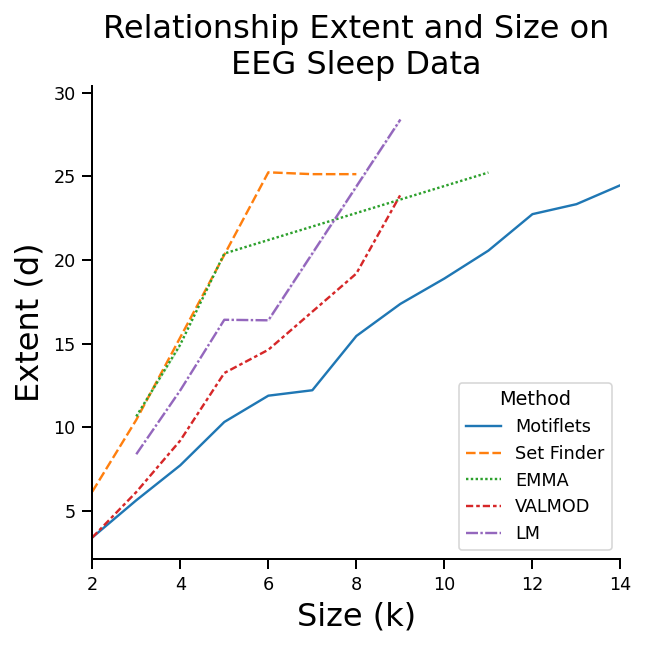

In [18]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(5,5))
ax.set_title("Relationship Extent and Size on\n" + ds_name)
sns.lineplot(x="k", y="Extent", data=df_comp, hue="Method", style="Method", ci=0)
sns.despine()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Size (k)")
ax.set_ylabel("Extent (d)")
ax.set_xlim([2, 14])
plt.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(5)
#plt.savefig("../images/" + ds_name.replace(" ", "-")  + "_compare2.pdf", bbox_inches='tight')